กำลังดึงข้อมูล BIDU ตั้งแต่ 2010-01-01 ถึง 2025-11-29...


C:\Users\USER\AppData\Local\Temp\ipykernel_17688\1950233724.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)['Close'].dropna()
[*********************100%***********************]  1 of 1 completed



              🔬 ส่วนที่ 1: Backtest ย้อนหลัง 365 วัน 🔬

              🔮 ส่วนที่ 2: Forecast ทำนาย 365 วัน ข้างหน้า 🔮


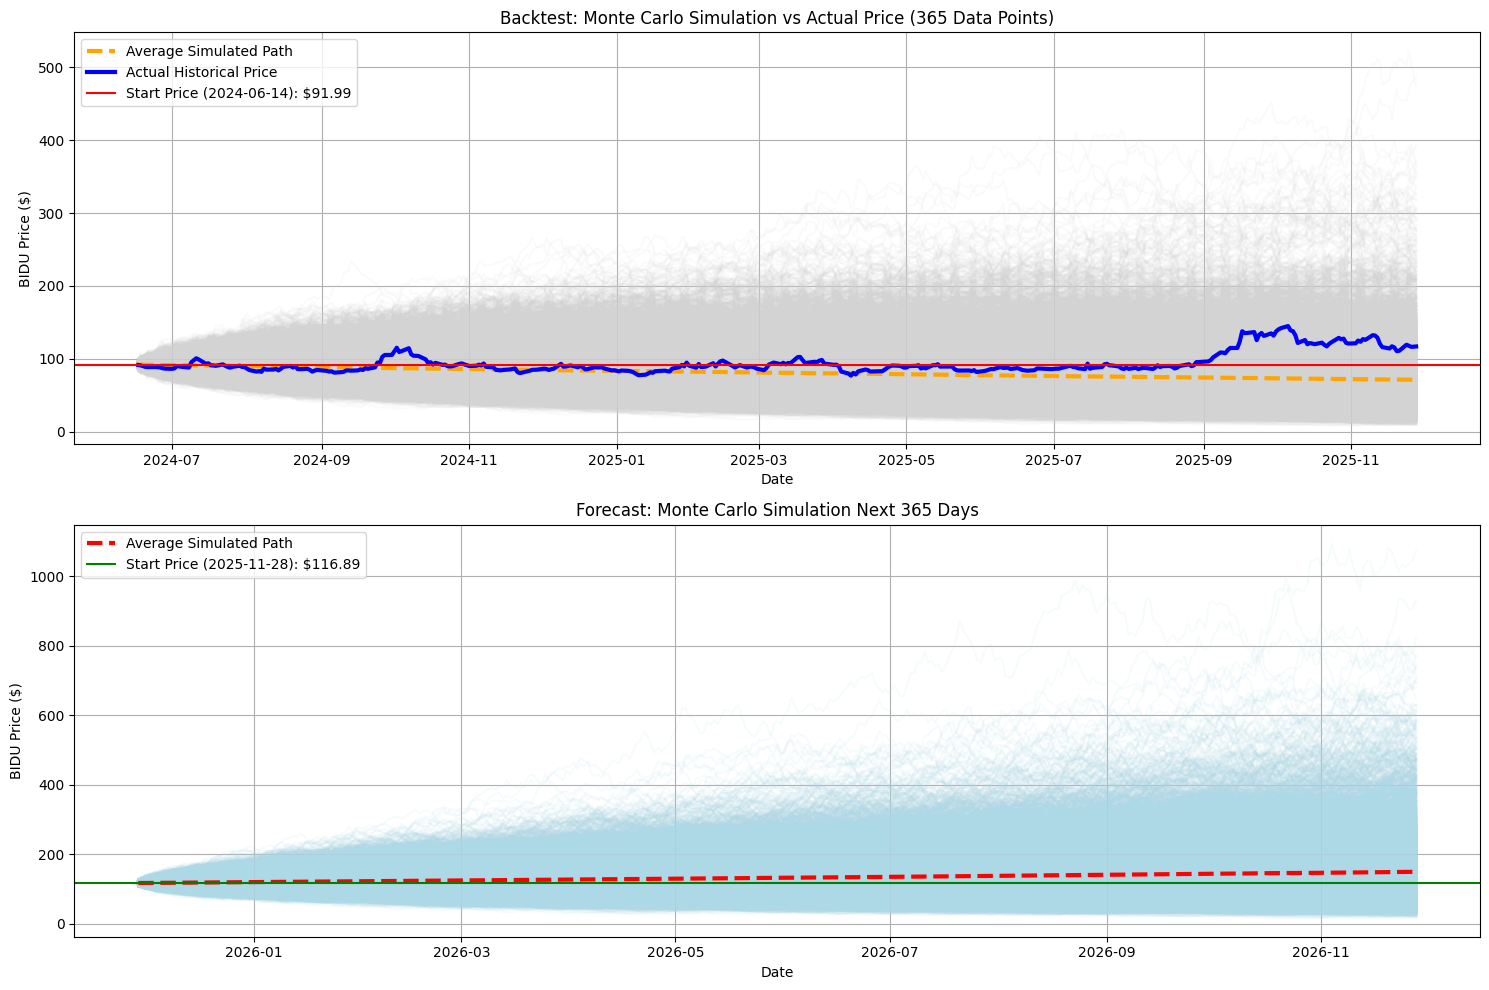


              📊 สรุปผล Backtest 365 วัน
  ราคาจริง ณ วันสุดท้ายของ Backtest: **$116.89**
  ราคาคาดการณ์เฉลี่ยจากการจำลอง: **$71.20**
  ช่วงความเชื่อมั่น 90% (5th - 95th Percentile) ของการจำลอง:
    $25.93 ถึง $147.92

  *** การประเมิน: ราคาจริงอยู่ภายในช่วงความเชื่อมั่นหรือไม่? ***
  ✅ ราคาจริง **อยู่ภายใน** ช่วงความเชื่อมั่น 90% ของการจำลอง (โมเดลอธิบายความผันผวนได้ดีในอดีต)

              🚀 สรุปผล Forecast 365 วัน
  ราคาเริ่มต้นการทำนาย: **$116.89**
  Volatility (sigma) ที่ใช้: **0.0288**
  Drift (แนวโน้ม) ที่ใช้: **0.0003**
  ราคาคาดการณ์เฉลี่ยใน 365 วัน: **$149.22**
  --------------------------------------------------
  ช่วงความเชื่อมั่น 90% (5th - 95th Percentile):
    - กรณีแย่สุด (5th): $51.76
    - กรณีดีสุด (95th): $315.42
------------------------------------------------------------


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

# ==============================================================================
# 1. การกำหนดตัวแปรหลัก (ผู้ใช้ต้องกำหนด 3 ตัวแปรนี้)
# ==============================================================================
ticker = 'BIDU'
num_simulations = 10000 

# --- ตัวแปรที่ผู้ใช้กำหนด ---
user_start_date_str = '2010-01-01'  # วันที่เริ่มต้นของชุดข้อมูลทั้งหมด (YYYY-MM-DD)
backtest_forecast_days = 365        # จำนวนจุดข้อมูลที่ใช้ในการ Backtest และ Forecast (เช่น 365 จุดข้อมูล)
# ----------------------------

# ==============================================================================
# 2. การเตรียมข้อมูล
# ==============================================================================

# คำนวณวันที่ที่จำเป็น
end_date = datetime.now() # วันที่สิ้นสุดของข้อมูลจริง (วันนี้)
try:
    start_date = datetime.strptime(user_start_date_str, '%Y-%m-%d')
except ValueError:
    print("❌ รูปแบบวันที่เริ่มต้นไม่ถูกต้อง กรุณาใช้ YYYY-MM-DD")
    exit()

print(f"กำลังดึงข้อมูล {ticker} ตั้งแต่ {start_date.strftime('%Y-%m-%d')} ถึง {end_date.strftime('%Y-%m-%d')}...")

# ดึงข้อมูลราคาปิดของสินทรัพย์
try:
    # .dropna() เพื่อลบวันที่ไม่มีข้อมูล เช่น วันหยุดทำการ (ถ้าเป็นหุ้น)
    data = yf.download(ticker, start=start_date, end=end_date)['Close'].dropna()
except Exception as e:
    print(f"เกิดข้อผิดพลาดในการดึงข้อมูล: {e}")
    exit()

# ตรวจสอบความยาวข้อมูลที่ต้องการ (ต้องมีอย่างน้อย 2 เท่าของช่วงเวลาที่ต้องการ)
required_data_points = backtest_forecast_days * 2
if len(data) < required_data_points:
    print(f"❌ ข้อผิดพลาด: ข้อมูลที่ดึงมามีเพียง {len(data)} จุดข้อมูล")
    print(f"ต้องมีอย่างน้อย {required_data_points} จุดข้อมูล (สำหรับ Backtest และ Forecast อย่างละ {backtest_forecast_days} จุด)")
    print(f"กรุณาเปลี่ยน start_date ให้ย้อนหลังไปอีก")
    exit()

# --- การแยกข้อมูลสำหรับ Backtest และ Forecast (อ้างอิงจากจำนวนจุดข้อมูล) ---
W = backtest_forecast_days 

# 2.1 Backtest Calculation Data (P1): ข้อมูลเก่า 1 หน้าต่าง
backtest_cal_data = data.iloc[-(2 * W):-W]

# 2.2 Real Data for Backtest (P2): ข้อมูลจริง 1 หน้าต่างล่าสุด (ใช้เปรียบเทียบ)
real_data_for_backtest = data.iloc[-W:]
backtest_steps = len(real_data_for_backtest)

# 2.3 Forecast Calculation Data: P2 (ใช้ข้อมูลล่าสุดในการทำนายอนาคต)
forecast_cal_data = real_data_for_backtest.copy()
forecast_steps = W 

# ==============================================================================
# 3. ฟังก์ชันสำหรับคำนวณและจำลอง Monte Carlo
# ==============================================================================

def run_monte_carlo(data_series, forecast_steps, num_sims):
    """ฟังก์ชันสำหรับรัน Monte Carlo Simulation และคืนค่าผลลัพธ์"""
    
    # 3.1 คำนวณค่าสถิติ
    log_returns = np.log(data_series / data_series.shift(1))
    
    sigma_series = log_returns.std()
    mu_series = log_returns.mean()
    
    try:
        sigma = sigma_series.item()
        mu = mu_series.item()
    except (ValueError, AttributeError): # จัดการทั้ง ValueError และ AttributeError
        sigma = sigma_series.mean()
        mu = mu_series.mean()

    drift = mu - (0.5 * sigma**2)
    last_price = data_series.iloc[-1].item() 
    
    # 3.2 การจำลอง
    Z = np.random.normal(size=(forecast_steps, num_sims))
    # simulations_full: สร้างแถวเผื่อ 1 แถวสำหรับราคาเริ่มต้น
    simulations_full = np.zeros((forecast_steps + 1, num_sims))
    simulations_full[0] = last_price

    for t in range(1, forecast_steps + 1):
        # ใช้ Z[t-1] เพราะ Z มีขนาด forecast_steps แต่ลูปเริ่มที่ 1 ถึง forecast_steps+1
        daily_returns = np.exp(drift + sigma * Z[t - 1] * np.sqrt(1)) 
        simulations_full[t] = simulations_full[t-1] * daily_returns
        
    # คืนค่าเฉพาะการจำลอง (ไม่รวมราคาเริ่มต้น)
    simulations = simulations_full[1:] # shape (forecast_steps, num_sims)
    
    # 3.3 สรุปผล
    avg_price = simulations.mean(axis=1) # shape (forecast_steps,)
    final_prices = simulations[-1, :]
    
    # สร้าง Index สำหรับพล็อต
    # Index ต้องมีขนาดเท่ากับ forecast_steps พอดี
    start_date_forecast = data_series.index[-1] + timedelta(days=1)
    # ใช้ periods=forecast_steps เพื่อให้ได้ขนาดที่แน่นอน (แก้ ValueError/TypeError)
    date_index = pd.date_range(start=start_date_forecast, periods=forecast_steps) 

    return simulations, avg_price, final_prices, date_index, last_price, drift, sigma


# ==============================================================================
# 4. A. Backtest ย้อนหลัง (ใช้ P1 คำนวณ ทำนาย P2)
# ==============================================================================

print("\n" + "="*60)
print(f"              🔬 ส่วนที่ 1: Backtest ย้อนหลัง {backtest_steps} วัน 🔬")
print("="*60)

backtest_sims, backtest_avg, backtest_final, backtest_index_simulated, backtest_start_price, _, _ = \
    run_monte_carlo(backtest_cal_data, backtest_steps, num_simulations)

# สำหรับการพล็อต Backtest เราใช้วันที่จริงของ P2 เป็นแกน X
backtest_index = real_data_for_backtest.index 

# ==============================================================================
# 4. B. Forecast ทำนาย 1 ปี ข้างหน้า (ใช้ P2 คำนวณ ทำนายอนาคต)
# ==============================================================================

print("\n" + "="*60)
print(f"              🔮 ส่วนที่ 2: Forecast ทำนาย {forecast_steps} วัน ข้างหน้า 🔮")
print("="*60)

forecast_sims, forecast_avg, forecast_final, forecast_index, forecast_start_price, drift_forecast, sigma_forecast = \
    run_monte_carlo(forecast_cal_data, forecast_steps, num_simulations)


# ==============================================================================
# 5. การแสดงผลลัพธ์ (Backtest และ Forecast)
# ==============================================================================

plt.figure(figsize=(15, 10))


# 5.1 Backtest Plot
plt.subplot(2, 1, 1)
# backtest_sims และ backtest_index (real_data_for_backtest.index) มีขนาดเท่ากัน
plt.plot(backtest_index, backtest_sims, color='lightgray', alpha=0.1) 
plt.plot(backtest_index, backtest_avg, color='orange', linestyle='--', linewidth=3, label='Average Simulated Path')
plt.plot(real_data_for_backtest.index, real_data_for_backtest.values, color='blue', linewidth=3, label='Actual Historical Price')
plt.axhline(y=backtest_start_price, color='red', linestyle='-', label=f'Start Price ({backtest_cal_data.index[-1].strftime("%Y-%m-%d")}): ${backtest_start_price:.2f}')
plt.title(f'Backtest: Monte Carlo Simulation vs Actual Price ({backtest_steps} Data Points)')
plt.xlabel('Date')
plt.ylabel(f'{ticker} Price ($)')
plt.legend()
plt.grid(True)

# 5.2 Forecast Plot
plt.subplot(2, 1, 2)
plt.plot(forecast_index, forecast_sims, color='lightblue', alpha=0.1)
plt.plot(forecast_index, forecast_avg, color='red', linestyle='--', linewidth=3, label='Average Simulated Path')
plt.axhline(y=forecast_start_price, color='green', linestyle='-', label=f'Start Price ({forecast_cal_data.index[-1].strftime("%Y-%m-%d")}): ${forecast_start_price:.2f}')
plt.title(f'Forecast: Monte Carlo Simulation Next {forecast_steps} Days')
plt.xlabel('Date')
plt.ylabel(f'{ticker} Price ($)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ==============================================================================
# 6. สรุปผลลัพธ์
# ==============================================================================

# 6.1 สรุป Backtest
backtest_actual_final_price = real_data_for_backtest.iloc[-1].item()
backtest_avg_final_price = backtest_avg[-1]
backtest_final_percentile_5 = np.percentile(backtest_final, 5)
backtest_final_percentile_95 = np.percentile(backtest_final, 95)

print("\n" + "="*60)
print(f"              📊 สรุปผล Backtest {backtest_steps} วัน")
print("="*60)
print(f"  ราคาจริง ณ วันสุดท้ายของ Backtest: **${backtest_actual_final_price:.2f}**")
print(f"  ราคาคาดการณ์เฉลี่ยจากการจำลอง: **${backtest_avg_final_price:.2f}**")
print(f"  ช่วงความเชื่อมั่น 90% (5th - 95th Percentile) ของการจำลอง:")
print(f"    ${backtest_final_percentile_5:.2f} ถึง ${backtest_final_percentile_95:.2f}")
print(f"\n  *** การประเมิน: ราคาจริงอยู่ภายในช่วงความเชื่อมั่นหรือไม่? ***")
if backtest_final_percentile_5 <= backtest_actual_final_price <= backtest_final_percentile_95:
    print("  ✅ ราคาจริง **อยู่ภายใน** ช่วงความเชื่อมั่น 90% ของการจำลอง (โมเดลอธิบายความผันผวนได้ดีในอดีต)")
else:
    print("  ❌ ราคาจริง **อยู่นอก** ช่วงความเชื่อมั่น 90% ของการจำลอง (โมเดลอาจมีข้อจำกัด)")


# 6.2 สรุป Forecast
print("\n" + "="*60)
print(f"              🚀 สรุปผล Forecast {forecast_steps} วัน")
print("="*60)
print(f"  ราคาเริ่มต้นการทำนาย: **${forecast_start_price:.2f}**")
print(f"  Volatility (sigma) ที่ใช้: **{sigma_forecast:.4f}**")
print(f"  Drift (แนวโน้ม) ที่ใช้: **{drift_forecast:.4f}**")
print(f"  ราคาคาดการณ์เฉลี่ยใน {forecast_steps} วัน: **${forecast_avg[-1]:.2f}**")
print(f"  --------------------------------------------------")
print(f"  ช่วงความเชื่อมั่น 90% (5th - 95th Percentile):")
print(f"    - กรณีแย่สุด (5th): ${np.percentile(forecast_final, 5):.2f}")
print(f"    - กรณีดีสุด (95th): ${np.percentile(forecast_final, 95):.2f}")
print("-" * 60)